In [1]:
import os
os.environ["WANDB_API_KEY"] = "KEY"
os.environ["WANDB_MODE"] = 'offline'

import numpy as np
import pandas as pd
import math
import re
import argparse
import random
import csv
import matplotlib.pyplot as plt
import tqdm
import itertools
from itertools import combinations
from PIL import Image

import torch
import torch.optim as optim
from torch import Tensor
import torch.nn as nn
import torchvision.transforms as transforms
from torch.nn import CrossEntropyLoss
from torch.nn import functional as F
from torch.optim import Adam
from torch.optim import AdamW
from torch.utils.data import DataLoader, Dataset
from sklearn.model_selection import train_test_split

from sklearn.metrics import confusion_matrix

import clip
import open_clip

from einops.layers.torch import Rearrange, Reduce


In [2]:
def load_ep_data(EP_folderpath, image_folderpath):
    EP_segmentation_list = os.listdir(EP_folderpath)
    print(f'Total Dataset Number: {len(EP_segmentation_list)}')
    
    EP_data_list = []
    image_list = []
    image_label_list = []
    EP_data_date_list = []
    
    for EP_data_dir in EP_segmentation_list:
        EP_data = np.load(os.path.join(EP_folderpath, EP_data_dir))
        image_label = EP_data_dir.split("_")[1]
        EP_data_date = EP_data_dir.split("_")[0]
        image = Image.open(os.path.join(image_folderpath, f"{image_label}.jpg")).convert("L")
        image_label = int(image_label) - 1
        
        EP_data_list.append(EP_data)
        image_list.append(image)
        image_label_list.append(image_label)
        EP_data_date_list.append(EP_data_date)

    return EP_data_list, image_list, image_label_list, EP_data_date_list

class EPDataset(Dataset):
    def __init__(self, EP_data, images, labels):
        self.EP_data = EP_data
        self.images = images  
        self.labels = labels
        self.max_pool = nn.MaxPool1d(kernel_size=5, stride=5)
        self.preprocess = transforms.Compose([
            transforms.Resize((224, 224)),
            transforms.ToTensor(),
            transforms.Normalize((0.48145466, 0.4578275, 0.40821073), 
            (0.26862954, 0.26130258, 0.27577711))
        ])

    def __len__(self):
        return len(self.EP_data)

    def __getitem__(self, idx):
        EP_tensor = torch.tensor(self.EP_data[idx], dtype=torch.float32)
        label = torch.tensor(int(self.labels[idx]), dtype=torch.long)
        image = self.preprocess(self.images[idx].convert("RGB"))  
        
        EP_tensor = EP_tensor.T        
        return EP_tensor, label, image

EP_folderpath = "/root/autodl-tmp/data_0403"
image_folderpath = "/root/visual_decode/NaturalImages_new_2"

EP_data, images, labels, EP_data_date = load_ep_data(
    EP_folderpath, 
    image_folderpath
)

train_idx, test_idx = train_test_split(
    range(len(EP_data)),
    test_size=0.2,
    stratify=labels,
    random_state=42
)

train_dataset = EPDataset(
    EP_data=[EP_data[i] for i in train_idx],
    images=[images[i] for i in train_idx],
    labels=[labels[i] for i in train_idx]
)

test_dataset = EPDataset(
    EP_data=[EP_data[i] for i in test_idx],
    images=[images[i] for i in test_idx],
    labels=[labels[i] for i in test_idx]
)

Total Dataset Number: 17924


In [3]:
torch.cuda.empty_cache()
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True, drop_last=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False, drop_last=True)

In [4]:
class ModelConfig:
    def __init__(self,
                 input_neuron=19,        # input neurons
                 time_bins=20,           # time step
                 d_model = 150,           # Transformer model dimension
                 nhead=10,                # attention head
                 num_transformer_layers=1, # Transformer layer number
                 conv_channels=64,       # conv channel number
                 num_conv_blocks=3,      # conv block number
                 num_classes=117,         # classes number
                 residual_dims=[256, 512, 1024], # residual dimension
                 use_positional_encoding=True,  
                 dim_feedforward_ratio=4,       # FeedForward dimension ratio
                 activation='relu',
                 use_neuron_masking=True,  
                 mask_ratio=0.25,
                 mask_replacement='random'):
        
        # Transformer 
        self.transformer = {
            'd_model': d_model,
            'nhead': nhead,
            'num_layers': num_transformer_layers,
            'dim_feedforward': d_model * dim_feedforward_ratio,
            'activation': activation
        }
        
        # cnn
        self.convolution = {
            'channels': conv_channels,
            'num_blocks': num_conv_blocks,
            'kernel_size': (3, 3),
            'pool_size': (2, 2)
        }
        
        # resnet
        self.residual = {
            'dims': residual_dims,
            'skip_connection': True
        }
        
        self.masking = {
            'enabled': use_neuron_masking,
            'ratio': mask_ratio,
            'replacement': mask_replacement
        }

        self.input_dim = input_neuron
        self.time_steps = time_bins
        self.num_classes = num_classes
        self.positional_encoding = use_positional_encoding
        self.lr = 2e-4
        self.epochs = 50

In [10]:
import torch
import torch.nn as nn
import math

class NeuronMasker(nn.Module):
    def __init__(self, mask_ratio=0.15, replacement='random'):
        super().__init__()
        self.mask_ratio = mask_ratio
        self.replacement = replacement
        
    def forward(self, x):
        if self.training:
            # 检查输入有效性
            if x is None:
                raise ValueError("Input tensor x is None")
                
            batch_size, seq_len, feat_dim = x.shape
            mask = torch.rand_like(x) < self.mask_ratio
            
            if self.replacement == 'zero':
                x_masked = x.masked_fill(mask, 0)
            elif self.replacement == 'random':
                random_values = torch.randn_like(x) * 0.02
                x_masked = x.masked_scatter(mask, random_values)
            else:
                raise ValueError(f"Invalid replacement: {self.replacement}")
            
            return x_masked 
        else:
            return x
        
class ResidualLinearBlock(nn.Module):
    def __init__(self, input_dim, output_dim):
        super().__init__()
        self.linear = nn.Linear(input_dim, output_dim)
        self.norm = nn.LayerNorm(output_dim)
        self.activation = nn.GELU()
        self.downsample = nn.Linear(input_dim, output_dim) if input_dim != output_dim else nn.Identity()

    def forward(self, x):
        residual = self.downsample(x)
        x = self.linear(x)
        x = self.norm(x)
        x = self.activation(x)
        return x + residual

class TimeTransformerConvModel(nn.Module):
    def __init__(self, config: ModelConfig):
        super().__init__()
        self.config = config
        
        self.input_proj = nn.Linear(config.input_dim, config.transformer['d_model'])
        self.pos_encoder = PositionalEncoding(config.transformer['d_model']) if config.positional_encoding else nn.Identity()

        self.clip_model, _, _ = open_clip.create_model_and_transforms('ViT-H-14', pretrained = '/root/autodl-tmp/open_clip_pytorch_model.bin', device = 'cuda')
        
        for name, param in self.clip_model.named_parameters():
            if "transformer.resblocks.22" in name or "transformer.resblocks.23" in name:
                param.requires_grad = True  
            else:
                param.requires_grad = False
                
        #self.clip_proj = nn.Linear(1024, 1024)
        
        transformer_layer = nn.TransformerEncoderLayer(
            d_model=config.transformer['d_model'],
            nhead=config.transformer['nhead'],
            dim_feedforward=config.transformer['dim_feedforward'],
            batch_first=True
        )
        self.transformer = nn.TransformerEncoder(transformer_layer, config.transformer['num_layers'])
        
        self.conv_blocks = nn.Sequential()
        in_channels = 1
        for _ in range(config.convolution['num_blocks']):
            self.conv_blocks.append(
                nn.Sequential(
                    nn.Conv2d(in_channels, config.convolution['channels'], 
                            kernel_size=config.convolution['kernel_size'], padding='same'),
                    nn.BatchNorm2d(config.convolution['channels']),
                    nn.ELU(),
                    nn.MaxPool2d(kernel_size=config.convolution['pool_size'])
                )
            )
            in_channels = config.convolution['channels']
        
        self.adaptive_pool = nn.AdaptiveAvgPool2d((1, 1))
        self.classifier = nn.Linear(config.convolution['channels'], config.num_classes)
        
        self.residual_layers = nn.Sequential()
        current_dim = config.convolution['channels']
        for dim in config.residual['dims']:
            self.residual_layers.append(ResidualLinearBlock(current_dim, dim))
            current_dim = dim
        if current_dim != 1024:
            self.residual_layers.append(nn.Linear(current_dim, 1024))
            self.residual_layers.append(nn.LayerNorm(1024))


        self.masker = NeuronMasker(
            mask_ratio=self.config.masking['ratio'],
            replacement=self.config.masking['replacement']
        )

    def forward(self, x, images):
        x = self.masker(x)  # [B, T, D]
        #print(x)
        x = self.input_proj(x)
        x = self.pos_encoder(x)
        x = self.transformer(x)
        
        x = x.unsqueeze(1)
        x = self.conv_blocks(x)
        x = self.adaptive_pool(x)
        x = x.flatten(1)
        
        logits = self.classifier(x)
        features = self.residual_layers(x)

        with torch.no_grad():
            img_feat = self.clip_model.encode_image(images)
        
        return logits, features, img_feat

class PositionalEncoding(nn.Module):
    def __init__(self, d_model: int, max_len: int = 5000):
        super().__init__()
        position = torch.arange(max_len).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2) * (-math.log(10000.0) / d_model))
        pe = torch.zeros(max_len, d_model)
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        self.register_buffer('pe', pe)

    def forward(self, x):
        x = x + self.pe[:x.size(1)]
        return x

In [11]:
class MultitaskLoss(nn.Module):
    def __init__(self, alpha=0.3, temp=0.07):
        super().__init__()
        self.alpha = alpha      # 分类损失权重
        self.temp = temp
        self.ce_loss = nn.CrossEntropyLoss()
        self.temp = temp
        
        self.ce_loss = nn.CrossEntropyLoss()
    
    def contrastive_loss(self, h_neuro, h_img):
        h_neuro = F.normalize(h_neuro, dim=1) + 1e-10
        h_img = F.normalize(h_img, dim=1) + 1e-10
        
        logits_ab = torch.matmul(h_neuro, h_img.T) / self.temp
        logits_ba = torch.matmul(h_img, h_neuro.T) / self.temp
        
        labels = torch.arange(h_neuro.size(0), device=h_neuro.device)
        loss_ab = F.cross_entropy(logits_ab, labels)
        loss_ba = F.cross_entropy(logits_ba, labels)
        
        return (loss_ab + loss_ba) / 2
    
    def forward(self, logits, labels, img_feature, features):
        loss_cls = self.ce_loss(logits, labels)
        loss_cont = self.contrastive_loss(features, img_feature)
        total_loss = self.alpha * loss_cls + (1 - self.alpha) * loss_cont
        return total_loss

In [12]:
def train_model(model, dataloader, optimizer, device, criterion, config):
    model.train()
    total_loss = 0.0
    correct = 0
    total = 0
        
    for batch_idx, (neuro, labels, images) in enumerate(dataloader):
        images = images.to(device)
        neuro = neuro.to(device)
        labels = labels.to(device)
        
        optimizer.zero_grad()
        
        logits, features, img_feature = model(neuro, images)
        loss = criterion(logits, labels, img_feature, features)
        
        loss.backward()
        torch.nn.utils.clip_grad_norm_(
            parameters=model.parameters(), 
            max_norm=3.0,                   
            norm_type=2.0                   
        )
        optimizer.step()
        
        # 统计指标
        total_loss += loss.item()
        _, predicted = torch.max(logits, 1)
        correct += (predicted == labels).sum().item()
        total += labels.size(0)
        
    train_loss = total_loss / len(dataloader)
    train_accuracy = correct / total
    return train_loss, train_accuracy

@torch.no_grad()
def evaluate_model(model, dataloader, device, criterion, config, image_cluster):
    model.eval()
    total_loss = 0.0
    correct_top1 = 0
    correct_top5 = 0
    correct_2way = 0
    correct_4way = 0
    correct_10way = 0
    total = 0
    
    # 从 DataFrame 创建聚类映射字典
    cluster_2_map = torch.tensor(image_cluster["2_cluster"].values, device=device)
    cluster_4_map = torch.tensor(image_cluster["4_cluster"].values, device=device)
    cluster_10_map = torch.tensor(image_cluster["10_cluster"].values, device=device)
    
    for neuro, labels, images in dataloader:
        neuro = neuro.to(device)
        labels = labels.to(device)
        images = images.to(device)
        
        logits, features, img_feature = model(neuro, images)
        
        loss = criterion(logits, labels, img_feature, features)
        total_loss += loss.item()
        
        # （Top-1 和 Top-5）
        _, predicted_top1 = torch.max(logits, 1)
        correct_top1 += (predicted_top1 == labels).sum().item()
        _, predicted_top5 = logits.topk(5, dim=1)
        correct_top5 += torch.sum(predicted_top5.eq(labels.view(-1, 1))).item()
        
        # (2-way, 4-way, 10-way)
        cluster_2_pred = cluster_2_map[predicted_top1]
        cluster_4_pred = cluster_4_map[predicted_top1]
        cluster_10_pred = cluster_10_map[predicted_top1]
        
        cluster_2_true = cluster_2_map[labels]
        cluster_4_true = cluster_4_map[labels]
        cluster_10_true = cluster_10_map[labels]
        
        correct_2way += (cluster_2_pred == cluster_2_true).sum().item()
        correct_4way += (cluster_4_pred == cluster_4_true).sum().item()
        correct_10way += (cluster_10_pred == cluster_10_true).sum().item()
        
        total += labels.size(0)
    
    test_loss = total_loss / len(dataloader)
    test_accuracy = correct_top1 / total
    top5_accuracy = correct_top5 / total
    accuracy_2way = correct_2way / total
    accuracy_4way = correct_4way / total
    accuracy_10way = correct_10way / total
    
    return test_loss, test_accuracy, top5_accuracy, accuracy_2way, accuracy_4way, accuracy_10way

In [13]:
def main_train_loop(config, model, train_loader, test_loader, device, image_cluster):
    optimizer = AdamW(model.parameters(), lr=config.lr)
    criterion = MultitaskLoss(alpha=0.7, temp=0.07)
    
    train_losses, train_accs = [], []
    test_losses, test_accs, test_top5, acc_2way, acc_4way, acc_10way = [], [], [], [], [], []
    best_acc = 0.0
    
    for epoch in range(config.epochs):
        train_loss, train_acc = train_model(
            model=model,
            dataloader=train_loader,
            optimizer=optimizer,
            device=device,
            criterion=criterion,
            config=config
        )
        
        test_loss, test_acc, top5_acc, accuracy_2way, accuracy_4way, accuracy_10way = evaluate_model(
            model=model,
            dataloader=test_loader,
            device=device,
            criterion=criterion,
            config=config,
            image_cluster = image_cluster
        )
        
        train_losses.append(train_loss)
        train_accs.append(train_acc)
        test_losses.append(test_loss)
        test_accs.append(test_acc)
        test_top5.append(top5_acc)
        acc_2way.append(accuracy_2way)
        acc_4way.append(accuracy_4way)
        acc_10way.append(accuracy_10way)
        
        
        if test_acc > best_acc:
            best_acc = test_acc
            torch.save(model.state_dict(), "best_model.pth")
        
        # 打印日志
        print(f"Epoch {epoch+1}/{config.epochs}")
        print(f"Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.2%}")
        print(f"Test Loss: {test_loss:.4f} | Test Acc: {test_acc:.2%} | Top-5 Acc: {top5_acc:.2%}")
        print(f"2-way Acc: {accuracy_2way:.2%} | 4-way Acc: {accuracy_4way:.2%} | 10-way Acc: {accuracy_10way:.2%}")
        print("-" * 60)
    
    plt.figure(figsize=(12, 4))
    
    plt.subplot(1, 2, 1)
    plt.plot(train_losses, label="Train")
    plt.plot(test_losses, label="Test")
    plt.title("Loss Curve")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend()
    
    plt.subplot(1, 2, 2)
    plt.plot(train_accs, label="Train Acc")
    plt.plot(test_accs, label="Test Acc")
    plt.plot(test_top5, label="Test Top-5")
    plt.title("Accuracy Curve")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.legend()
    
    plt.tight_layout()
    plt.savefig("training_results.png")
    
    return {
        "best_test_acc": best_acc,
        "final_top5_acc": test_top5[-1],
        "train_history": {
            "loss": train_losses,
            "accuracy": train_accs
        },
        "test_history": {
            "loss": test_losses,
            "accuracy": test_accs,
            "top5_accuracy": test_top5,
            "acc_2way": acc_2way,
            "acc_4way": acc_4way,
            "acc_10way": acc_10way
        }
    }

Epoch 1/50
Train Loss: 4.5011 | Train Acc: 1.37%
Test Loss: 4.3012 | Test Acc: 2.79% | Top-5 Acc: 10.63%
2-way Acc: 48.94% | 4-way Acc: 25.78% | 10-way Acc: 14.06%
------------------------------------------------------------
Epoch 2/50
Train Loss: 4.1601 | Train Acc: 3.72%
Test Loss: 4.0001 | Test Acc: 4.52% | Top-5 Acc: 17.66%
2-way Acc: 51.06% | 4-way Acc: 29.41% | 10-way Acc: 18.86%
------------------------------------------------------------
Epoch 3/50
Train Loss: 3.9913 | Train Acc: 4.83%
Test Loss: 3.9086 | Test Acc: 5.13% | Top-5 Acc: 20.70%
2-way Acc: 51.17% | 4-way Acc: 30.22% | 10-way Acc: 18.53%
------------------------------------------------------------
Epoch 4/50
Train Loss: 3.9035 | Train Acc: 5.26%
Test Loss: 4.0909 | Test Acc: 4.19% | Top-5 Acc: 17.30%
2-way Acc: 50.11% | 4-way Acc: 28.85% | 10-way Acc: 17.75%
------------------------------------------------------------
Epoch 5/50
Train Loss: 3.8350 | Train Acc: 6.37%
Test Loss: 3.8579 | Test Acc: 5.80% | Top-5 Acc: 22

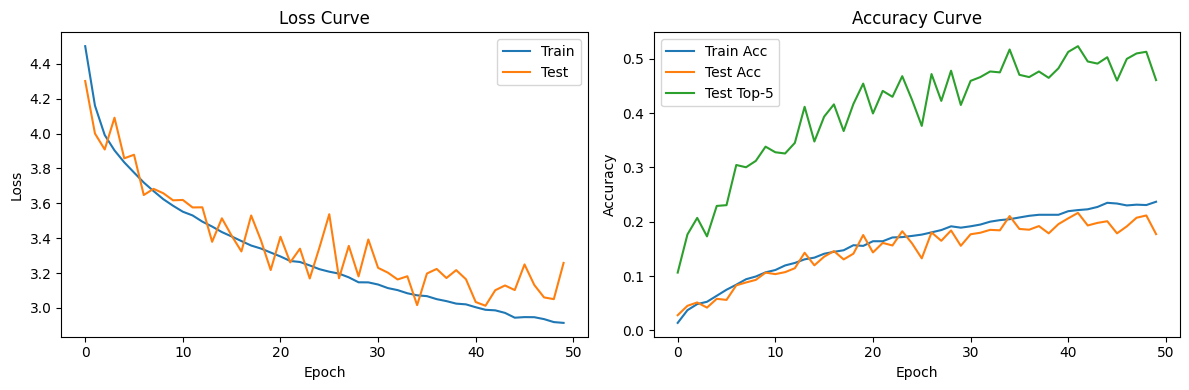

In [14]:
config = ModelConfig()

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = TimeTransformerConvModel(config).to(device)

image_cluster = pd.read_csv("image_cluster.csv")
results = main_train_loop(
    config=config,
    model=model,
    train_loader=train_loader,
    test_loader=test_loader,
    device=device,
    image_cluster = image_cluster
)